# Analysis and data exploration: Ratings + Text dataset

## Table of Contents 
1. [Data cleaning](#s1)
1. a. [Data exploration](#s1s1)
1. b. [Language detection](#s1s2)
2. [Topic detection](#s2)
2. a. [TF-IDF](#s2s1)
2. b. [NMF](#s2s2)
3. [Conclusion](#s3)

## Data cleaning <a name='s1'></a>

### Data exporation <a name='s1s1'></a>

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from langdetect import detect
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import json
from yelp_text_preprocessing  import *

### Import csv to pandas dataframe

In [2]:
df_ratings = pd.read_csv('dataset/Text+Ratings.csv/data')

/home/lio/.python-env/default/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Let's see some data

In [3]:
df_ratings.sample(3)

cool        date funny               review_id  stars  \
306112    0  2016-10-20     0  gjOBcJhPQVAIw0hadlvs4g    2.0   
378695    0  2016-04-20     0  BzzNCQaf08XG96Olq-OLMA    5.0   
314315    4  2009-10-19     3  IaSAXVpSUaprikYLRHNZBA    3.0   

                                                     text  useful  \
306112  When I moved to the area, I thought I would tr...     1.0   
378695  My daughter and I stopped by for lunch. It was...     0.0   
314315  Highlights of Sunday's trip to Dandelion: \n- ...     4.0   

                       user_id  
306112  bX_hZjz3PQCYCEaNMfZdaw  
378695  uMAS0idkHY6nkZhz6psRVA  
314315  22MhrUQrcamK25LYcTBe4A

### Let's see the information to detect missing fields

In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500001 entries, 0 to 500000
Data columns (total 8 columns):
cool         500001 non-null object
date         500001 non-null object
funny        500001 non-null object
review_id    500000 non-null object
stars        500000 non-null float64
text         500000 non-null object
useful       499999 non-null float64
user_id      499999 non-null object
dtypes: float64(2), object(6)
memory usage: 30.5+ MB


#### Then drop na

In [5]:
df_ratings.dropna(inplace=True)

#### Convert objet columns to numeric

In [6]:
df_ratings["funny"] = pd.to_numeric(df_ratings["funny"])
df_ratings["cool"] = pd.to_numeric(df_ratings["cool"])

### Now we can see information on the numeric variables

In [7]:
df_ratings.describe()

cool          funny          stars         useful
count  499999.000000  499999.000000  499999.000000  499999.000000
mean        0.586365       0.496565       3.732523       1.385283
std         2.406367       2.412440       1.450461       4.221156
min         0.000000       0.000000       1.000000       0.000000
25%         0.000000       0.000000       3.000000       0.000000
50%         0.000000       0.000000       4.000000       0.000000
75%         1.000000       0.000000       5.000000       2.000000
max       208.000000     521.000000       5.000000     832.000000

#### Add a column with the number of characters in the text

In [8]:
df_ratings['length_text'] = list(map(lambda x: len(" ".join(str(x).split())),df_ratings['text']))

### Let's see the distribution of text lengths for each star

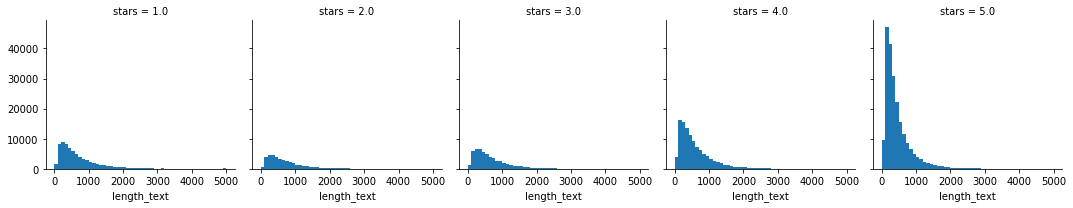

In [9]:
g = sns.FacetGrid(data=df_ratings, col='stars')
g.map(plt.hist, 'length_text', bins=50)

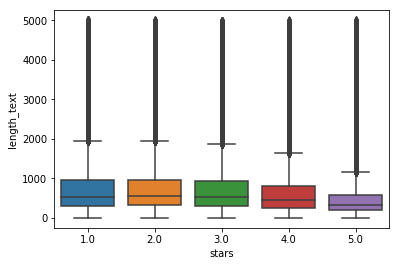

In [11]:
sns.boxplot(x='stars', y='length_text', data=df_ratings)

We can see that in all the groupings the data have a distribution with an asymmetry.
The distribution of the length of reviews is simliar for each star rating.
The most extreme case is the 5 stars


#### How balanced is our target?

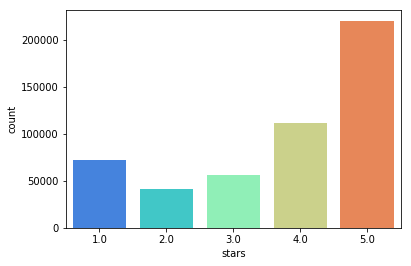

In [12]:
sns.countplot(x='stars',data=df_ratings,palette='rainbow')

#### Let's see the information of the texts with less than 2000

In [14]:
df_ratings[df_ratings['length_text'] < 2000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485077 entries, 0 to 500000
Data columns (total 9 columns):
cool           485077 non-null int64
date           485077 non-null object
funny          485077 non-null int64
review_id      485077 non-null object
stars          485077 non-null float64
text           485077 non-null object
useful         485077 non-null float64
user_id        485077 non-null object
length_text    485077 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 37.0+ MB


### Let's see the information of the numerical variables grouped by star

In [15]:
features_mean_by_stars = df_ratings.groupby('stars').mean()

In [16]:
features_mean_by_stars

cool     funny    useful  length_text
stars                                           
1.0    0.263170  0.665413  2.174836   753.232805
2.0    0.421367  0.655095  1.609301   754.810645
3.0    0.674803  0.624074  1.392658   709.653358
4.0    0.862526  0.576160  1.397655   619.677785
5.0    0.560798  0.339213  1.077040   477.676958

In [17]:
features_mean_by_stars.corr()

cool     funny    useful  length_text
cool         1.000000 -0.259631 -0.689378    -0.439208
funny       -0.259631  1.000000  0.749986     0.973039
useful      -0.689378  0.749986  1.000000     0.778728
length_text -0.439208  0.973039  0.778728     1.000000

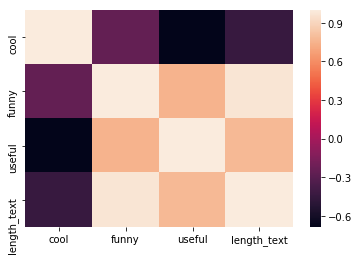

In [18]:
sns.heatmap(features_mean_by_stars.corr())

### Language detection <a name='s1s2'></a>

### I found texts in other languages. Let's see the distribution by language.

#### First we detect the language of each text.

In [20]:
errors = []
text_errors = []
def compute_language(text):
    try:
        if str(text) == "" :
            return None
        else:
            return detect(str(text))
        
    except Exception as e:
        errors.append(e)
        text_errors.append(text)

Next operation takes approximately 30 minutes

In [21]:
df_ratings['lang' ] = list(map(compute_language,tqdm(df_ratings['text']) ))

#### Text distribution by language

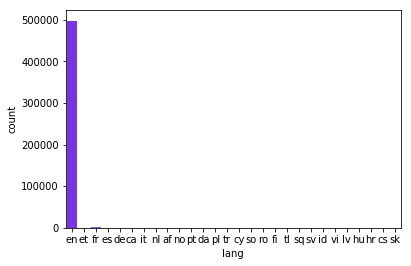

In [24]:
sns.countplot(x='lang',data=df_ratings,palette='rainbow')

In [26]:
df_ratings.query('lang == "en"').count()

cool           497308
date           497308
funny          497308
review_id      497308
stars          497308
text           497308
useful         497308
user_id        497308
length_text    497308
lang           497308
dtype: int64

#### Let's see the texts that do not have language

In [27]:
df_ratings[pd.isna(df_ratings['lang'] )].sample(10)

cool        date  funny               review_id  stars  \
87523      1  2015-06-03      1  Qs0lpDbg-Ce0COHDs00UsQ    4.0   
198776     1  2014-09-17      0  VLs87S1gFYeYEa2vOTmApw    4.0   
60819      0  2017-07-25      0  uU9YamNna5xI-tmVVxmTJQ    4.0   
142369     0  2017-03-24      0  p02uQ-lVw2x8EP3bejQqbQ    4.0   
85212      3  2016-01-11      0  IJ5iu9YkfohTt0wjiFZYBA    3.0   
315479     1  2018-06-26      0  LUmvjrWE0rtE0-TuTCRjog    5.0   
177192     0  2015-09-25      0  Z1BPdu28m5dkiV7V8OyoBA    4.0   
177531     2  2017-04-11      0  EOPTGlBn_V2BvqzxaRpmdw    5.0   
28429      0  2017-01-18      1  mNVynIfEREUV6ttpEXav6A    4.0   
106613     0  2015-09-08      0  8iW3t1oh1Q45S047lmONCQ    5.0   

                                                     text  useful  \
87523   ???????????\n??????????...\n??????????????????...     1.0   
198776  ??????????????????40??????????\n??????????????...     0.0   
60819   ???? ?????????????????????????????????????????...     0.0   
142369  ??????????????????????????????????????????????...     0.0   
85212                     ???????????????????????????????     3.0   
315479  ??????????????????\n??????????????3?4?????????...     0.0   
177192                               ????\n\n???\n??\n???     0.0   
177531  ???????????????????????????\n\n???????????????...     0.0   
28429   ?????????????????????????\n????????\n????$8 / ...     2.0   
106613  ??????????????????????????????????????????????...     2.0   

                       user_id  length_text  lang  
87523   5GDLuKrsWVxa72aB_gzajw          150  None  
198776  9qcLqIVOjKlKORjlORg6VA          123  None  
60819   616YkHWAu3at3r79GWbQcA           58  None  
142369  GU1D9T0gyEn-iEGxEOsTLQ           88  None  
85212   vk1qxhb7biknD1G_9B5t7w           31  None  
315479  JzcGe74qaxAfkXAngTBK3g          119  None  
177192  w0PGaBMEUjYPSqUYGeU1sw           15  None  
177531  GVm4q4jy7pI1IyRz5vClBQ          312  None  
28429   61GUwNcv9SB0JYxr6iLPXA           96  None  
106613  rhAFpqcM4fQ7bj4W1ACdRA          167  None

#### Store clean data

In [29]:
df_ratings.query('lang == "en"',inplace=True)

In [30]:
#df_ratings.to_csv('clean_ratings.csv')

## Topic detection <a name='s2'></a>

#### We split 1 and 2 star reviews into negative reviews and 4 and 5 star reviews into positive reviews.

In [54]:
pos_reviews = df_ratings.text[df_ratings.stars>3]
neg_reviews = df_ratings.text[df_ratings.stars<3]
print('# Postive Reviews =>  {}'.format(len(pos_reviews)))
print('# Negative Reviews =>  {}'.format(len(neg_reviews)))

# Postive Reviews =>  329220
# Negative Reviews =>  112502


### TF-IDF <a name='s2s1'></a>

In [55]:
stopwords = get_stopwords()

In [63]:
tfidf_pos = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

In [64]:
pos_vectors = tfidf_pos.fit_transform(pos_reviews) 

In [65]:
tfidf_neg = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

In [66]:
neg_vectors = tfidf_neg.fit_transform(neg_reviews)

In [67]:
#pos_vectors, tfidf_pos = get_tfidf_vectors(pos_reviews,stop_words=stopwords)
#neg_vectors, tfidf_neg = get_tfidf_vectors(neg_reviews,stop_words=stopwords)


In [151]:
def print_most_important_words(word_list,columns,limit):
    words_with_index = [ (i,x) for i,x in  enumerate(np.array(word_list.mean(axis=0)).flatten())]
    aux=1
    for pos,value in sorted(neg_words, key=lambda t: t[1],reverse=True)[:limit]:
        print("#{} word => {}".format(aux,columns[pos]))
        aux +=1

In [152]:
print_most_important_words(neg_vectors,tfidf_neg.get_feature_names(),8)

#1 word => food
#2 word => service
#3 word => place
#4 word => get
#5 word => time
#6 word => would
#7 word => like
#8 word => back


In [153]:
print_most_important_words(pos_vectors,tfidf_pos.get_feature_names(),8)

#1 word => decor
#2 word => longos
#3 word => hyderabadi
#4 word => difficulties
#5 word => northeastern
#6 word => pinned
#7 word => flax
#8 word => apts


### The result does not serve to conclude anything. Let's try the NMF algorithm

### NMF <a name='s2s2'></a>

In [154]:
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

In [155]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.878*chicken, 1.608*delicious, 1.354*ordered, 1.095*menu, 1.091*restaurant, 1.080*try
Topic 1:   1.336*time, 0.905*would, 0.828*get, 0.784*us, 0.721*one, 0.717*back
Topic 2:   4.654*great, 2.655*food, 2.638*service, 0.851*excellent, 0.800*atmosphere, 0.626*awesome
Topic 3:   3.602*love, 3.355*place, 3.312*always, 1.553*staff, 1.506*friendly, 1.162*best
Topic 4:   5.705*pizza, 0.850*crust, 0.413*wings, 0.410*cheese, 0.395*best, 0.390*thin
Topic 5:   4.664*good, 1.440*really, 1.239*food, 0.914*nice, 0.792*place, 0.742*pretty

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.247*would, 1.236*car, 1.146*told, 1.127*back, 1.121*said, 1.062*get
Topic 1:   1.353*chicken, 1.040*like, 0.978*ordered, 0.934*good, 0.702*place, 0.673*sauce
Topic 2:   2.032*us, 1.596*minutes, 1.317*order, 1.105*table, 0.903*came, 0.779*waited
Topic 3:   4.401*pizza, 0.556*order, 0.4

## Conclusion:

1. <div>There is a positive correlation between the length of the text and usefull. The same goes for usefull and funny.
On the other hand there is a negative correlation between cool and useful.</div>
2. <div>We have an unbalanced dataset</div>
3. <div>The distribution of the length of reviews is simliar for each star rating. The most extreme case is the 5 stars</div>
4. <div>The most important words obtained by TfIdf are not very useful to get some visual analysis. As it will be seen in the machine learning models, tfidf vectors will be very helpful.</div>
5. <div>As future work, it was still pending to visualize the embeddings with dimension reduction using, for example, tsne.</div>